# Pancreatlas - Human Pancreas Biomolecular Imaging Data


This notebook serves as a guided tour of the [Pancreatlas](https://registry.opendata.aws/pancreatlas) dataset. More usage examples, tutorials, and documentation for this dataset and others can be found at the [Registry of Open Data on AWS](https://registry.opendata.aws/).

Pancreatlas is a collection of over 4,259 pancreas-specific biomolecular images from 908 de-identified organ donors, curated for interactive browsing at [pancreatlas.org](https://www.pancreatlas.org/). Data was generated using tissue from organ donors studied by multiple national and international phenotyping programs. The dataset spans the human lifespan (birth to 79 years) and includes donors with non-diabetic, type 1 diabetes (T1D), type 2 diabetes (T2D), cystic fibrosis-related diabetes (CFRD), neonatal diabetes (NDM), autoantibody-positive (AAB), and atypical diabetes (ATDM) phenotypes. Expression patterns of 70+ proteins are visualized across the dataset by immunohistochemistry and others, in addition to rich information from traditional histological imaging.

### Citation

Saunders DC, Messmer J, Kusmartseva I, Beery ML, Yang M, Atkinson MA, Powers AC, Cartailler JP, Brissova M. Pancreatlas: Applying an Adaptable Framework to Map the Human Pancreas in Health and Disease. Patterns (N Y). 2020 Oct 5;1(8):100120. doi: 10.1016/j.patter.2020.100120. PMID: 33294866; PMCID: PMC7691395.

### TL;DR

The data is at `s3://pancreatlas-human-pancreas-biomolecular-imaging`

## Data organization

At the top level of the `pancreatlas` S3 bucket there are two key prefixes and one top-level file:

1. **`README.txt`** — Overview of the dataset and usage guidance
2. **`metadata/`** — Tabular metadata files describing the full dataset:
   - `image_metadata.csv` — One row per image: donor demographics, disease status, imaging modality, markers, quantitative histopathology scores, etc
   - `collection_metadata.csv` — One row per collection (10 collections): research program summaries, image counts, and publication references
   - `nomenclature.csv` — Data dictionary: definitions for all abbreviations, metadata fields, antibody targets, and staining reagents used across the dataset
3. **`images/`** — Raw image files, partitioned by collection using Hive-style prefixes:

```
s3://pancreatlas/
├── README.txt
├── metadata/
│   ├── image_metadata.csv
│   ├── collection_metadata.csv
│   └── nomenclature.csv
└── images/
    ├── dataset_id=410/       # Cystic Fibrosis-Related Diabetes (CFRD), 86 images
    ├── dataset_id=508/       # Human Pancreas Analysis Program (HPAP), 1,192 images
    ├── dataset_id=525/       # nPOD case #6362 (T1D example), 39 images
    ├── dataset_id=531/       # Neonatal Development & Early Life Pancreas (HANDEL-P), 457 images
    ├── dataset_id=703/       # Exocrine pancreas in type 1 diabetes, 135 images
    ├── dataset_id=853/       # Integrated Islet Distribution Program (IIDP),pancr 930 images
    ├── dataset_id=904/       # Early-stage type 2 diabetes, 112 images
    ├── dataset_id=960/       # Exeter Archival Diabetes Biobank (EADB), 345 images
    ├── dataset_id=1120/      # Exocrine pancreas pathophysiology, 446 images
    └── dataset_id=1129/      # Pediatric immune tissue development (HANDEL-I), 575 images
```

The Hive-style partition format (`dataset_id=XXX`) allows users to access images from a specific research collection using a simple S3 prefix filter, without scanning the entire dataset. Full documentation, including a complete data dictionary, is available at [pancreatlas.org/nomenclature](https://www.pancreatlas.org/nomenclature).

In [25]:
# Import libs
import io
from collections import Counter
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from botocore import UNSIGNED
from botocore.config import Config

In [26]:
# Configuration
# Set USE_LOCAL = True to load metadata from local CSV files
# Set USE_LOCAL = False to load from the S3 bucket
USE_LOCAL = True

# Local CSV paths — relative to this notebook's directory
# The '_out' / '_output' suffixes are artifacts of the local export; the S3
# copies will be named image_metadata.csv, collection_metadata.csv, nomenclature.csv.
LOCAL_IMAGE_METADATA      = 'image_metadata_out.csv'
LOCAL_COLLECTION_METADATA = 'collection_metadata_out.csv'
LOCAL_NOMENCLATURE        = 'nomenclature_output.csv'


First, we define the location of the dataset, create our boto3 S3 client, and list the top-level contents of the bucket. Because this is a public bucket, requests do not need to be signed.

In [27]:
# S3 bucket for the Pancreatlas dataset
bucket = "pancreatlas-human-pancreas-biomolecular-imaging"

if USE_LOCAL:
    print("Running in local mode — S3 connection skipped.")
    print("Set USE_LOCAL = False (in the configuration cell) to connect to the S3 bucket.")
else:
    # Public bucket — no credentials needed
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    response = s3.list_objects_v2(Bucket=bucket, Delimiter='/')

    print("Top-level prefixes:")
    for item in response.get('CommonPrefixes', []):
        print(f"  {item['Prefix']}")

    print("\nTop-level files:")
    for item in response.get('Contents', []):
        print(f"  {item['Key']}")

Running in local mode — S3 connection skipped.
Set USE_LOCAL = False (in the configuration cell) to connect to the S3 bucket.


Within the `images/` prefix, images are partitioned by `dataset_id`, where each value corresponds to one of Pancreatlas's ten research collections.

In [28]:
if USE_LOCAL:
    print("Running in local mode — S3 prefix listing skipped.")
else:
    response = s3.list_objects_v2(Bucket=bucket, Prefix='images/', Delimiter='/')
    print("Collections available under images/:")
    for item in response.get('CommonPrefixes', []):
        print(f"  {item['Prefix']}")

Running in local mode — S3 prefix listing skipped.


Let's look more closely at one collection — the Human Pancreas Analysis Program (HPAP, `dataset_id=508`), the largest collection in the dataset with over 1,100 images spanning H&E, imaging mass cytometry (IMC), and CODEX multiplexed imaging.

In [29]:
if USE_LOCAL:
    print("Running in local mode — S3 file listing skipped.")
else:
    response = s3.list_objects_v2(
        Bucket=bucket,
        Prefix='images/dataset_id=508/',
        MaxKeys=10
    )
    print("Example files in the HPAP collection (first 10):")
    for obj in response.get('Contents', []):
        size_mb = obj['Size'] / 1e6
        print(f"  {obj['Key']}  ({size_mb:.0f} MB)")

Running in local mode — S3 file listing skipped.


### Q: What data formats are present in your dataset? What kinds of data are stored using these formats? Can you give any advice for how you work with these data formats?

Pancreatlas contains whole-slide and fluorescence microscopy images in several specialist formats alongside tabular CSV metadata files. The image formats each reflect the scanner or microscopy platform used to acquire the data:

| Format | Full Name | Typical Use in Pancreatlas | Suggested Python Tools |
|--------|-----------|---------------------------|------------------------|
| **SVS** | Aperio/Leica ScanScope Virtual Slide | Brightfield H&E, IHC whole-slide scans | `openslide-python`, `tifffile` |
| **NDPI** | Hamamatsu NanoZoomer Digital Pathology Image | Brightfield whole-slide scans | `openslide-python` |
| **OME-TIFF** | Open Microscopy Environment TIFF | Fluorescence IHC (multi-channel) | `tifffile`, `aicsimageio` |
| **QPTIFF** | Akoya/PerkinElmer Quantitative Pathology TIFF | CODEX multiplexed imaging | `tifffile`, `aicsimageio` |
| **LIF** | Leica Image File | Confocal fluorescence imaging | `readlif`, `aicsimageio` |
| **LSM** | Zeiss Laser Scanning Microscopy | Confocal fluorescence imaging | `tifffile`, `aicsimageio` |
| **TIFF** | Tagged Image File Format | General fluorescence/histology | `tifffile`, `PIL` |

Most image files are **pyramidal** — they store multiple resolution levels from full resolution down to a thumbnail overview, enabling efficient access at different zoom levels without loading the entire file. Individual whole-slide images range from ~50 MB to several GB.

The `image_metadata.csv`, `collection_metadata.csv`, and `nomenclature.csv` files are standard comma-separated value (CSV) files readable by any spreadsheet software or Python's `pandas` library.

For working with Pancreatlas images on AWS:
- **`openslide-python`** supports SVS, NDPI, and many TIFF variants; it can read individual tiles or resolution levels without downloading the full file
- **`tifffile`** and **`aicsimageio`** are recommended for OME-TIFF, QPTIFF, and LSM formats
- **[Amazon SageMaker](https://aws.amazon.com/sagemaker/)** provides managed Jupyter environments suitable for deep learning on image data, with direct S3 access
- **[AWS Batch](https://aws.amazon.com/batch/)** is useful for running parallelized image analysis pipelines across the full dataset

## Example of downloading and loading data

Starting with the metadata files, the `image_metadata.csv` file describes every image with per-image donor, sample, and imaging information.

In [35]:
if USE_LOCAL:
    image_metadata = pd.read_csv(LOCAL_IMAGE_METADATA)
else:
    response = s3.get_object(Bucket=bucket, Key='metadata/image_metadata.csv')
    image_metadata = pd.read_csv(io.BytesIO(response['Body'].read()))

print(f"Shape: {image_metadata.shape[0]:,} rows x {image_metadata.shape[1]} columns")
image_metadata.head(3)

Shape: 4,260 rows x 48 columns


,Image Name,Dataset ID,Description,ADM,Acinar Tissue (%),Acinar atrophy,Age,Age at Onset,Alpha Cells (%),Amyloid prevalence (%),...,Program,Program ID,RRID,Residual ICIs,Sample Type,Section Plane,Sex,Source,Trichrome (%),Markers
0,nPOD_6362-T1D-24y-M-Body,525,NaN,NaN,NaN,NaN,24y,NaN,NaN,NaN,...,nPOD,nPOD_6362,NaN,NaN,Tissue,Sagittal,M,Organ donor,NaN,CD45; Hematoxylin; SST
1,nPOD_6362-T1D-24y-M-Body,525,NaN,NaN,NaN,NaN,24y,NaN,NaN,NaN,...,nPOD,nPOD_6362,NaN,NaN,Tissue,Sagittal,M,Organ donor,NaN,Hematoxylin; INS; Ki67
2,nPOD_6362-T1D-24y-M-Body,525,NaN,NaN,NaN,NaN,24y,NaN,NaN,NaN,...,nPOD,nPOD_6362,NaN,NaN,Tissue,Sagittal,M,Organ donor,NaN,CD3; GCG; Hematoxylin


Each row corresponds to one image. The `Image Name` field encodes key attributes: program, donor case ID, disease type, age, sex, and pancreas region (e.g., `HPAP_6001-ND-22y-M-Body`). Key fields include:

- **Donor info**: `Age`, `Sex`, `Disease Status`, `Disease Type`, `Disease Duration`, `Age at Onset`
- **Sample info**: `Pancreas Region`, `Processing Type`, `Section Plane`, `Sample Type`
- **Image info**: `Modality`, `File Type`, `Markers`
- **Quantitative scores** (where available): `Beta Cells (%)`, `Alpha Cells (%)`, `Insulitis`, `Trichrome (%)`, `ADM`, and more

You can also load collection-level metadata, which describes the individual studies from which the data was obtained.

In [36]:
if USE_LOCAL:
    collection_metadata = pd.read_csv(LOCAL_COLLECTION_METADATA)
else:
    response = s3.get_object(Bucket=bucket, Key='metadata/collection_metadata.csv')
    collection_metadata = pd.read_csv(io.BytesIO(response['Body'].read()))

# Show a tidy summary of collections and their image counts
summary = collection_metadata[['Collection Name', 'Collection ID', 'img_count', 'img_types']].copy()
summary.columns = ['Collection', 'Dataset ID', 'Images', 'Image Types']
summary = summary.sort_values('Images', ascending=False).reset_index(drop=True)
print(summary.to_string(index=False))

                                           Collection  Dataset ID  Images                                     Image Types
               Human Pancreas Analysis Program (HPAP)         508    1192             Whole-slide scans (H&E, CODEX), IMC
         Integrated Islet Distribution Program (IIDP)         853     930                             Islet gels (FL IHC)
       Pediatric immune tissue development (HANDEL-I)        1129     575                         Whole-slide scans (H&E)
Neonatal Development & Early Life Pancreas (HANDEL-P)         531     457   Whole-slide scans (FL IHC), confocal (FL IHC)
                    Exocrine pancreas pathophysiology        1120     446              Whole-slide scans (H&E, histology)
              Exeter Archival Diabetes Biobank (EADB)         960     345                    Whole-slide scans (H&E, IHC)
                 Exocrine pancreas in type 1 diabetes         703     135           Whole-slide scans (FL IHC, histology)
                        

For loading actual image files, Pancreatlas uses pyramidal whole-slide image formats. The `openslide-python` library is the recommended tool for SVS and NDPI files — it supports reading individual tiles and resolution levels without loading the entire file into memory.

The example below demonstrates how to access a thumbnail (lowest-resolution overview) from an SVS file stored in S3 by downloading it to a temporary location.

In [ ]:
if USE_LOCAL:
    print("Image loading requires S3 access — skipped in local mode.")
    print("Set USE_LOCAL = False and ensure openslide-python is installed to run this section.")
else:
    import os
    import tempfile

    try:
        import openslide

        # Pick one SVS image from the metadata
        svs_rows = image_metadata[image_metadata['File Type'] == 'SVS']
        if svs_rows.empty:
            print("No SVS entries found in File Type column; skipping openslide example.")
        else:
            example_row = svs_rows.iloc[0]
            example_key = f"images/dataset_id={int(example_row['Dataset ID'])}/{example_row['Image Name']}.svs"
            print(f"Loading: {example_key}")

            with tempfile.NamedTemporaryFile(suffix='.svs', delete=False) as tmp:
                s3.download_fileobj(bucket, example_key, tmp)
                tmp_path = tmp.name

            slide = openslide.OpenSlide(tmp_path)
            print(f"Full resolution dimensions: {slide.dimensions[0]:,} x {slide.dimensions[1]:,} pixels")
            print(f"Number of pyramid levels:   {slide.level_count}")

            thumbnail = slide.get_thumbnail((512, 512))

            fig, ax = plt.subplots(1, 1, figsize=(5, 5), facecolor='white')
            ax.imshow(thumbnail)
            ax.set_title(example_row['Image Name'], fontsize=9)
            ax.axis('off')
            plt.tight_layout()
            plt.show()

            slide.close()
            os.unlink(tmp_path)

    except ImportError:
        print("openslide-python is not installed.")
        print("Install the OpenSlide C library (https://openslide.org/download/)")
        print("then: pip install openslide-python")

Image loading requires S3 access — skipped in local mode.
Set USE_LOCAL = False and ensure openslide-python is installed to run this section.


### Scope and composition of the dataset

The `image_metadata.csv` provides a rich basis for exploring the scope and composition of Pancreatlas. Below we generate several visualizations showing how images are distributed across disease status, donor age, imaging modality, and antibody/stain targets.

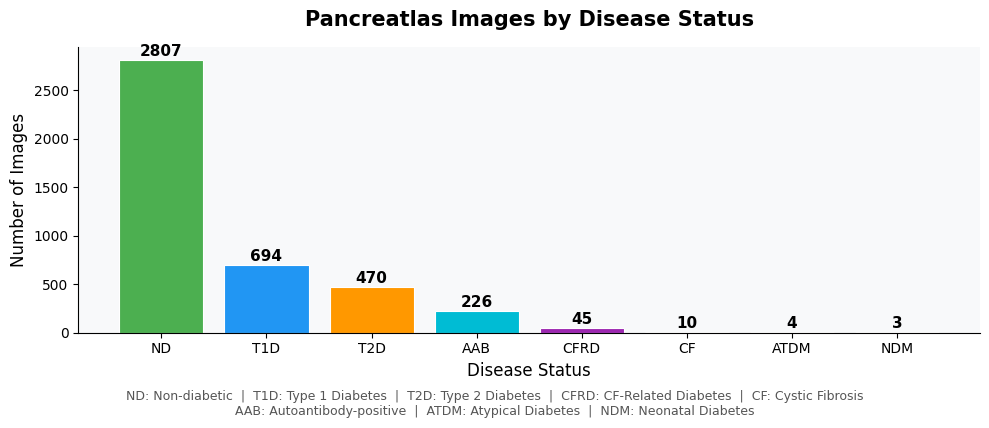

In [42]:
# Color palette for disease status categories
DISEASE_COLORS = {
    'ND':   '#4CAF50',  # green   — Non-diabetic
    'T1D':  '#2196F3',  # blue    — Type 1 Diabetes
    'T2D':  '#FF9800',  # orange  — Type 2 Diabetes
    'CFRD': '#9C27B0',  # purple  — Cystic Fibrosis-Related Diabetes
    'CF':   '#CE93D8',  # light purple — Cystic Fibrosis (no diabetes)
    'AAB':  '#00BCD4',  # teal    — Autoantibody-positive
    'ATDM': '#F44336',  # red     — Atypical Diabetes
    'NDM':  '#795548',  # brown   — Neonatal Diabetes
}

disease_counts = image_metadata['Disease Status'].value_counts()
colors = [DISEASE_COLORS.get(d, '#9E9E9E') for d in disease_counts.index]

fig, ax = plt.subplots(figsize=(10, 4), facecolor='white')
bars = ax.bar(disease_counts.index, disease_counts.values,
              color=colors, edgecolor='white', linewidth=0.8)

for bar, val in zip(bars, disease_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 12,
            str(val), ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Pancreatlas Images by Disease Status', fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Disease Status', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_facecolor('#f8f9fa')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend = ('ND: Non-diabetic  |  T1D: Type 1 Diabetes  |  T2D: Type 2 Diabetes  |  '
          'CFRD: CF-Related Diabetes  |  CF: Cystic Fibrosis\n'
          'AAB: Autoantibody-positive  |  ATDM: Atypical Diabetes  |  NDM: Neonatal Diabetes')
fig.text(0.5, -0.05, legend, ha='center', fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

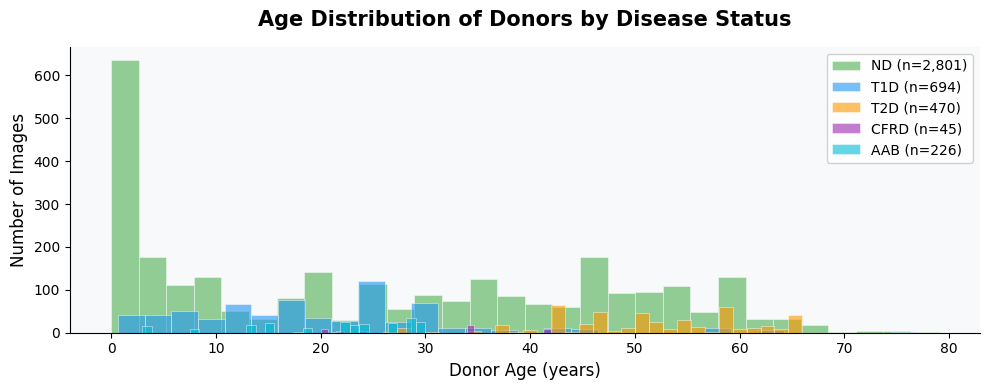

In [43]:
# Parse age strings (e.g. '24y', '6mo', '5d') to fractional years
def parse_age_years(age_str):
    if pd.isna(age_str):
        return None
    s = str(age_str).strip()
    if s.endswith('y'):
        return float(s[:-1])
    elif s.endswith('mo'):
        return float(s[:-2]) / 12
    elif s.endswith('d'):
        return float(s[:-1]) / 365
    return None

image_metadata['Age_years'] = image_metadata['Age'].apply(parse_age_years)

# Plot age distribution for the five most represented disease categories
diseases_to_plot = ['ND', 'T1D', 'T2D', 'CFRD', 'AAB']
plot_data = image_metadata[
    image_metadata['Disease Status'].isin(diseases_to_plot) &
    image_metadata['Age_years'].notna()
]

fig, ax = plt.subplots(figsize=(10, 4), facecolor='white')

for disease in diseases_to_plot:
    subset = plot_data[plot_data['Disease Status'] == disease]['Age_years']
    ax.hist(subset, bins=30, alpha=0.6,
            label=f'{disease} (n={len(subset):,})',
            color=DISEASE_COLORS[disease], edgecolor='white', linewidth=0.5)

ax.set_title('Age Distribution of Donors by Disease Status', fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Donor Age (years)', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.legend(fontsize=10, framealpha=0.9)
ax.set_facecolor('#f8f9fa')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

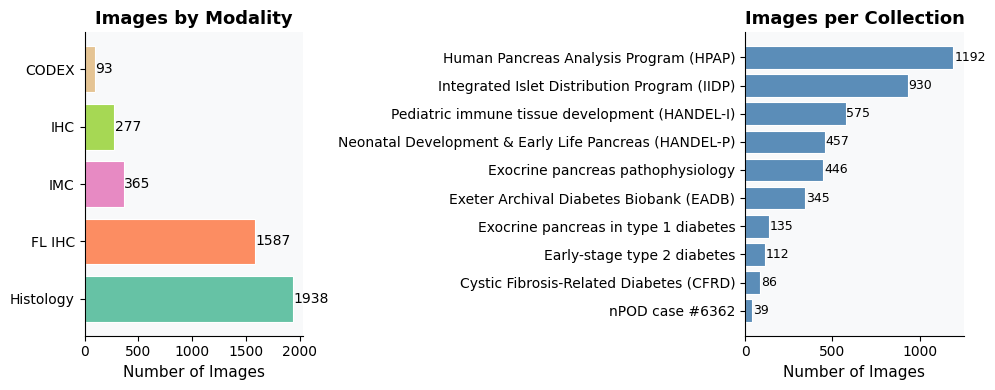

In [44]:
# Side-by-side: imaging modality breakdown + images per collection
modality_counts = image_metadata['Modality'].value_counts()
collection_img_counts = (
    collection_metadata
    .set_index('Collection Name')['img_count']
    .sort_values()
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), facecolor='white')

# Left: modality
mod_colors = plt.cm.Set2([i / len(modality_counts) for i in range(len(modality_counts))])
bars = axes[0].barh(modality_counts.index, modality_counts.values,
                    color=mod_colors, edgecolor='white', linewidth=0.8)
for bar, val in zip(bars, modality_counts.values):
    axes[0].text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2,
                 str(val), va='center', fontsize=10)
axes[0].set_title('Images by Modality', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Images', fontsize=11)
axes[0].set_facecolor('#f8f9fa')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Right: per-collection image counts
axes[1].barh(collection_img_counts.index, collection_img_counts.values,
             color='#5B8DB8', edgecolor='white', linewidth=0.8)
for i, val in enumerate(collection_img_counts.values):
    axes[1].text(val + 5, i, str(val), va='center', fontsize=9)
axes[1].set_title('Images per Collection', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Images', fontsize=11)
axes[1].set_facecolor('#f8f9fa')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

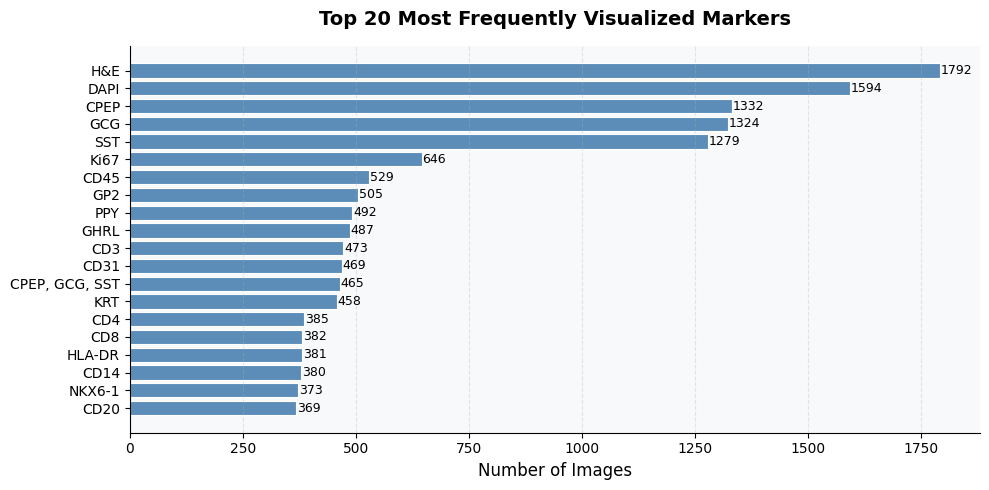

Total unique markers/stains across the dataset: 89


In [46]:
# Marker distribution
all_markers = []
for entry in image_metadata['Markers'].dropna():
    for marker in str(entry).split(';'):
        m = marker.strip()
        if m:
            all_markers.append(m)

marker_counts = Counter(all_markers)
top_markers = pd.Series(marker_counts).sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
ax.barh(top_markers.index[::-1], top_markers.values[::-1],
        color='#5B8DB8', edgecolor='white', linewidth=0.8)

for i, val in enumerate(top_markers.values[::-1]):
    ax.text(val + 2, i, str(val), va='center', fontsize=9)

ax.set_title('Top 20 Most Frequently Visualized Markers', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Number of Images', fontsize=12)
ax.set_facecolor('#f8f9fa')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total unique markers/stains across the dataset: {len(marker_counts)}")

## What is one question that you have answered using these data?

**How does the availability of different imaging modalities vary across disease types and research programs?**

One of Pancreatlas's core contributions is consolidating images from multiple independent research programs, each of which used different imaging platforms, staining protocols, and donor populations. Before using the dataset for analysis, it is essential to understand which modalities are represented for which disease types — and which combinations are well-powered.

Below, we cross-tabulate imaging modality against disease status to reveal the composition of the dataset. This kind of mapping helps researchers quickly identify relevant, well-powered subsets for their specific analysis.

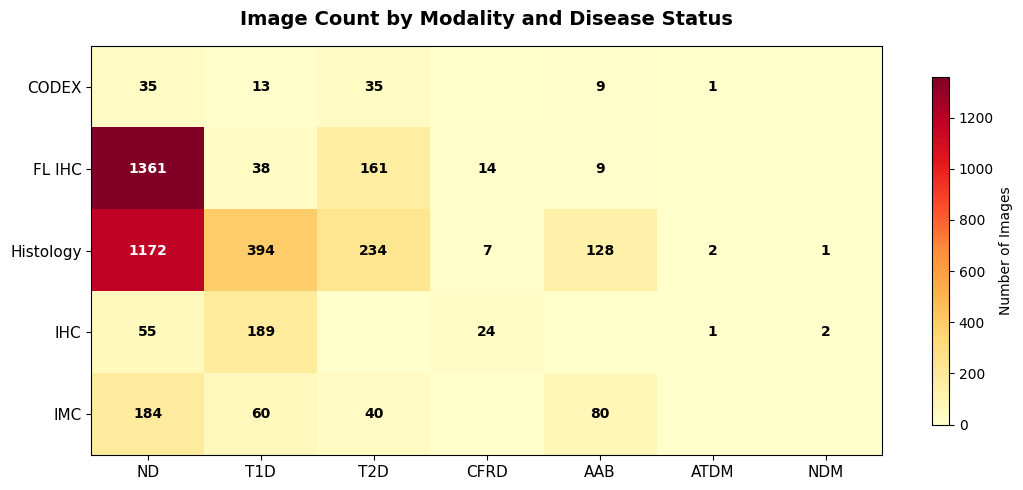


Row totals by modality:
Modality
Histology    1938
FL IHC       1583
IMC           364
IHC           271
CODEX          93


In [49]:
# Cross-tabulate: modality vs. disease status
main_diseases = ['ND', 'T1D', 'T2D', 'CFRD', 'AAB', 'ATDM', 'NDM']
cross_tab = pd.crosstab(
    image_metadata['Modality'],
    image_metadata['Disease Status']
)
cross_tab = cross_tab[[col for col in main_diseases if col in cross_tab.columns]]

fig, ax = plt.subplots(figsize=(11, 5), facecolor='white')
im = ax.imshow(cross_tab.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(cross_tab.columns)))
ax.set_xticklabels(cross_tab.columns, fontsize=11)
ax.set_yticks(range(len(cross_tab.index)))
ax.set_yticklabels(cross_tab.index, fontsize=11)

vmax = cross_tab.values.max()
for i in range(len(cross_tab.index)):
    for j in range(len(cross_tab.columns)):
        val = cross_tab.values[i, j]
        if val > 0:
            text_color = 'white' if val > vmax * 0.55 else 'black'
            ax.text(j, i, str(val), ha='center', va='center',
                    fontsize=10, fontweight='bold', color=text_color)

ax.set_title('Image Count by Modality and Disease Status', fontsize=14, fontweight='bold', pad=15)
plt.colorbar(im, ax=ax, label='Number of Images', shrink=0.85)
plt.tight_layout()
plt.show()

print("\nRow totals by modality:")
print(cross_tab.sum(axis=1).sort_values(ascending=False).to_string())

### What is one unanswered question that you think could be answered using these data?

**Challenge: Learn the cellular and structural signatures of diabetes subtypes directly from tissue images**

Pancreatlas images were acquired from donors representing seven distinct disease phenotypes, each with characteristic patterns of islet architecture, immune infiltration, beta cell loss, and fibrosis visible in histological and immunofluorescence images. Most of what we currently know about these patterns comes from expert-driven, labor-intensive manual scoring. We challenge the community to develop machine learning models that automate and scale this knowledge:

1. **Classify disease subtype from H&E images alone.** Can the structural changes associated with different forms of diabetes be detected without immunostaining? The dataset contains matched H&E and IHC images from many donors, enabling both training and interpretability analysis. The HPAP (`dataset_id=508`) and EADB (`dataset_id=960`) collections are well-powered starting points for ND vs. T1D classification.

2. **Quantify beta cell loss across the human lifespan.** Images stained for C-peptide/insulin (CPEP, INS) and glucagon (GCG) span donors from birth to age 79. Can a model learn the natural trajectory of beta cell mass — and detect deviations in autoantibody-positive or early-stage T1D donors? The HANDEL-P (`dataset_id=531`) and HPAP collections are particularly relevant here.

3. **Detect insulitis at scale.** Insulitis — immune cell infiltration of islets — is a defining but rare pathological feature of T1D. A sensitive, scalable detector trained on the `Insulitis` metadata field would accelerate our understanding of T1D onset timing and heterogeneity.

**Recommendations for getting started:**
- Use `image_metadata.csv` to filter and stratify a well-powered subset before downloading images; the `Disease Status`, `Modality`, `Markers`, and `Insulitis` fields are particularly useful
- `openslide-python` with patch extraction is the standard approach for deep learning on whole-slide images; the [CLAM framework](https://github.com/mahmoodlab/CLAM) provides a good starting point for weakly-supervised WSI classification
- Be mindful of tissue processing variability: the `Processing Type` field (FFPE, OCT-FF, etc.) and `Program` field are important covariates; consult `nomenclature.csv` for definitions
- AWS SageMaker and direct S3 access make it straightforward to train and evaluate models at scale without downloading the full dataset locally